## Project 3 - Explainable AI

In [1]:
import pandas as pd   
import numpy as np

import xgboost as xgb
import lightgbm as lgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('diabetes_prediction_dataset.csv')
data2 = data.copy()
data2

gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140         0  
1              6.6                   80         0  
2              5.7                  158         0  
3              5.0                  155         0  
4              4.8                  155         0  
...            ...                  ...       ...  
99995          6.2                   90         0  
99996          6.5                  100         0  
99997          5.7                  155         0  
99998          4.0                  100         0  
99999          6.6                   90         0  

[100000 rows x 9 columns]

In [3]:
print(data2.shape)
print(data2.columns)
print(data2.dtypes)

(100000, 9)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [4]:
#removing records where age of the patient is less than 2, and changing data type of age to INT
data2 = data2[data2['age'] >= 2]
data2['age'] = data2['age'].astype(int)

#merging and cleaning multiple similar values in smoking history
smoking_history_mapping = {'not current' : 'former', 'ever' : 'current', 'No Info' : 'unrevealed'}
data2['smoking_history'] = data2['smoking_history'].replace(smoking_history_mapping)
data2['smoking_history'] = data2['smoking_history'].apply(lambda x: x.split()[0])

#converting bmi of people over 60, because the weight can be in pounds which needs to be converted into kgs for homogenity
bmi_validity = data2['bmi'] > 60
data2.loc[bmi_validity, 'bmi'] = data2.loc[bmi_validity, 'bmi'] / 2.205

C:\Users\hadi.khan\AppData\Local\Temp\ipykernel_23256\2909780168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['age'] = data2['age'].astype(int)
C:\Users\hadi.khan\AppData\Local\Temp\ipykernel_23256\2909780168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['smoking_history'] = data2['smoking_history'].replace(smoking_history_mapping)
C:\Users\hadi.khan\AppData\Local\Temp\ipykernel_23256\2909780168.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [5]:
data2

gender  age  hypertension  heart_disease smoking_history    bmi  \
0      Female   80             0              1           never  25.19   
1      Female   54             0              0      unrevealed  27.32   
2        Male   28             0              0           never  27.32   
3      Female   36             0              0         current  23.45   
4        Male   76             1              1         current  20.14   
...       ...  ...           ...            ...             ...    ...   
99995  Female   80             0              0      unrevealed  27.32   
99996  Female    2             0              0      unrevealed  17.37   
99997    Male   66             0              0          former  27.83   
99998  Female   24             0              0           never  35.42   
99999  Female   57             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140         0  
1              6.6                   80         0  
2              5.7                  158         0  
3              5.0                  155         0  
4              4.8                  155         0  
...            ...                  ...       ...  
99995          6.2                   90         0  
99996          6.5                  100         0  
99997          5.7                  155         0  
99998          4.0                  100         0  
99999          6.6                   90         0  

[97899 rows x 9 columns]

In [6]:
print ('Unique Values in Smoking History: ',data2['smoking_history'].unique())
print ('Unique Values in Gender: ',data2['gender'].unique())
print ('Min and Max Ages: ',data2['age'].min(), ' and ', data2['age'].max())

Unique Values in Smoking History:  ['never' 'unrevealed' 'current' 'former']
Unique Values in Gender:  ['Female' 'Male' 'Other']
Min and Max Ages:  2  and  80


In [7]:
print(data2.shape)
print(data2.columns)
print(data2.dtypes)

(97899, 9)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')
gender                  object
age                      int32
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [8]:
data2.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [9]:
enc_data = pd.get_dummies(data2)
enc_data

age  hypertension  heart_disease    bmi  HbA1c_level  \
0       80             0              1  25.19          6.6   
1       54             0              0  27.32          6.6   
2       28             0              0  27.32          5.7   
3       36             0              0  23.45          5.0   
4       76             1              1  20.14          4.8   
...    ...           ...            ...    ...          ...   
99995   80             0              0  27.32          6.2   
99996    2             0              0  17.37          6.5   
99997   66             0              0  27.83          5.7   
99998   24             0              0  35.42          4.0   
99999   57             0              0  22.43          6.6   

       blood_glucose_level  diabetes  gender_Female  gender_Male  \
0                      140         0              1            0   
1                       80         0              1            0   
2                      158         0              0            1   
3                      155         0              1            0   
4                      155         0              0            1   
...                    ...       ...            ...          ...   
99995                   90         0              1            0   
99996                  100         0              1            0   
99997                  155         0              0            1   
99998                  100         0              1            0   
99999                   90         0              1            0   

       gender_Other  smoking_history_current  smoking_history_former  \
0                 0                        0                       0   
1                 0                        0                       0   
2                 0                        0                       0   
3                 0                        1                       0   
4                 0                        1                       0   
...             ...                      ...                     ...   
99995             0                        0                       0   
99996             0                        0                       0   
99997             0                        0                       1   
99998             0                        0                       0   
99999             0                        1                       0   

       smoking_history_never  smoking_history_unrevealed  
0                          1                           0  
1                          0                           1  
2                          1                           0  
3                          0                           0  
4                          0                           0  
...                      ...                         ...  
99995                      0                           1  
99996                      0                           1  
99997                      0                           0  
99998                      1                           0  
99999                      0                           0  

[97899 rows x 14 columns]

In [10]:
y = enc_data[['diabetes']]

In [11]:
enc_data2=enc_data.drop(['diabetes'],axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(enc_data2, np.ravel(y), test_size=0.3, random_state=2)

## PyCaret Model Selection

In [13]:
from pycaret.classification import *

In [14]:
Pycaretmodel = setup(data2, target='diabetes')
best_model = compare_models()
tuned_model = tune_model(best_model)

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## ADABoost

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_curve, auc
import time
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Define the AdaBoost classifier
AdaBoost = AdaBoostClassifier()

start_time = time.time()

# Define the hyperparameter grid to search over
params = {
    'n_estimators': np.arange(50, 200, 10),
    'learning_rate': np.logspace(-3, 0, 4),
}

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform the randomized search with cross-validation
rs = RandomizedSearchCV(
    AdaBoost, param_distributions=params, n_iter=50, cv=cv, verbose=False, random_state=42,
    scoring='roc_auc'  # Set AUC as the metric to optimize
)

# Fit the randomized search on the training data
rs.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best Hyperparameters:", rs.best_params_)
print("Best Score (AUC):", rs.best_score_)

# Use the best hyperparameters to train the model
best_params = rs.best_params_
model = AdaBoostClassifier(**best_params)
model.fit(X_train, y_train)

# Generate predictions for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]


end_time = time.time()
time_taken = end_time - start_time
print("Time taken: {:.2f} seconds".format(time_taken))

Best Hyperparameters: {'n_estimators': 70, 'learning_rate': 1.0}
Best Score (AUC): 0.9791776073117487
Time taken: 1275.21 seconds


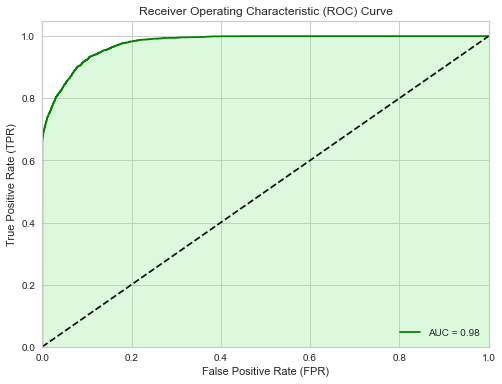

In [174]:
# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

# Generate the AUC curve with color
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label='AUC = {:.2f}'.format(auc_score))
plt.fill_between(fpr, tpr, color='lightgreen', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## LightGBM 

In [180]:
import lightgbm as lgb
import time
from sklearn.model_selection import RandomizedSearchCV, KFold

start_time = time.time()

# Define the LightGBM classifier
LGBM = lgb.LGBMClassifier()

# Define the hyperparameter grid to search over
params = {
    'num_leaves': np.arange(10, 100, 10),
    'max_depth': np.arange(3, 12, 1),
    'learning_rate': np.logspace(-3, 0, 4),
    'min_child_samples': np.arange(10, 60, 10),
    'subsample': np.arange(0.1, 1.1, 0.1),
    'colsample_bytree': np.arange(0.1, 1.1, 0.1),
}

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform the randomized search with cross-validation
rs = RandomizedSearchCV(
    LGBM, param_distributions=params, n_iter=50, cv=cv, verbose=False, random_state=42,
    scoring='roc_auc'  # Set AUC as the metric to optimize
)

# Fit the randomized search on the training data
rs.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best Hyperparameters:", rs.best_params_)
print("Best Score (AUC):", rs.best_score_)


end_time = time.time()

time_taken = end_time - start_time

print("Time taken: {:.2f} seconds".format(time_taken))

Best Hyperparameters: {'subsample': 1.0, 'num_leaves': 80, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Score (AUC): 0.9791296045708127
Time taken: 162.21 seconds


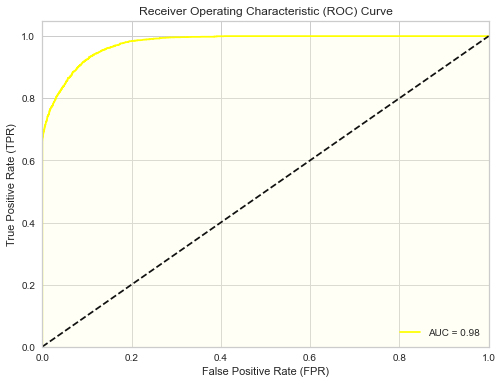

In [181]:
# Generate predictions for the test set
y_pred_proba = rs.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

# Generate the AUC curve with color
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='yellow', label='AUC = {:.2f}'.format(auc_score))
plt.fill_between(fpr, tpr, color='lightyellow', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## CatBoost

In [19]:
import catboost as cb
import time
CatB = cb.CatBoostClassifier()

start_time = time.time()

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Perform grid search using GridSearchCV
grid_search = GridSearchCV(estimator=CatB, param_grid=param_grid, cv=3)
grid_search.fit(enc_data2, y,verbose=False)

# Get the best hyperparameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score (AUC):", grid_search.best_score_)


end_time = time.time()

time_taken = end_time - start_time

print("Time taken: {:.2f} seconds".format(time_taken))

Best Parameters: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best Score (AUC): 0.9715829579464549
Time taken: 920.37 seconds


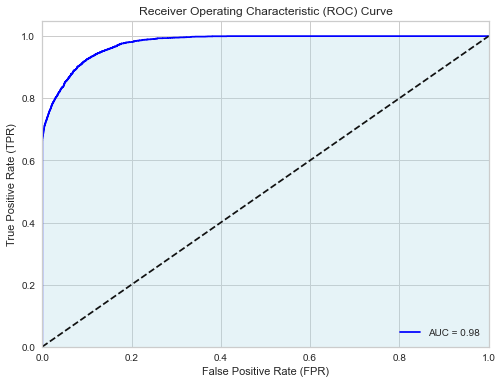

In [177]:
# Generate predictions for the test set
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

# Generate the AUC curve with color
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label='AUC = {:.2f}'.format(auc_score))
plt.fill_between(fpr, tpr, color='lightblue', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Gradient Boosting

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint as sp_randint

In [21]:
start_time = time.time()
param_dist = {"learning_rate": [0.05, 0.1, 0.15, 0.2],
              "max_depth": sp_randint(2, 10),
              "max_features": sp_randint(2, 10),
              "n_estimators": sp_randint(100, 1000)}

# Create the classifier object
gb_clf = GradientBoostingClassifier()

# Create the randomized search object
rand_search = RandomizedSearchCV(gb_clf, param_distributions = param_dist, n_iter=10, cv=5)

# Fit the randomized search object to the data
rand_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters found: ", rand_search.best_params_)

# Print the best score
print("Best Score (AUC):", rand_search.best_score_)

end_time = time.time()

time_taken = end_time - start_time

print("Time taken: {:.2f} seconds".format(time_taken))

Best hyperparameters found:  {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 5, 'n_estimators': 350}
Best Score (AUC): 0.9715740649006209
Time taken: 1346.43 seconds


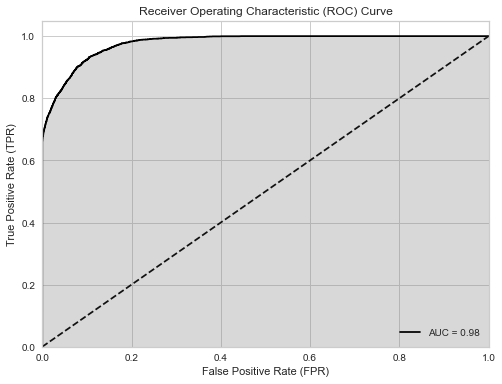

In [178]:
# Generate predictions for the test set
y_pred_proba = rand_search.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

# Generate the AUC curve with color
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='black', label='AUC = {:.2f}'.format(auc_score))
plt.fill_between(fpr, tpr, color='gray', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## XG Boost

In [22]:
start_time = time.time()
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # example values for the number of estimators
    'max_depth': [2, 3, 4, 5],  # example values for the maximum depth
    'learning_rate': [0.1, 0.01, 0.001],  # example values for the learning rate
}

xgb_model = xgb.XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10, cv=3)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

end_time = time.time()

time_taken = end_time - start_time

print("Time taken: {:.2f} seconds".format(time_taken))

Best parameters: {'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.1}
Best score: 0.9715594857651505
Time taken: 39.86 seconds


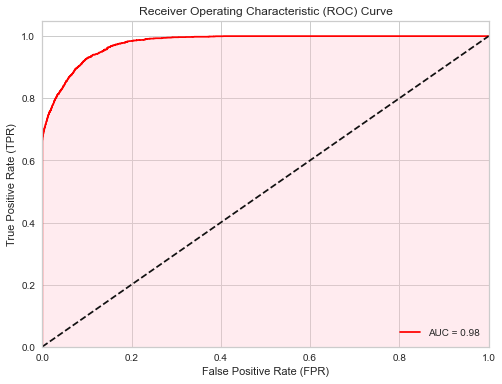

In [179]:
# Generate predictions for the test set
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

# Generate the AUC curve with color
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label='AUC = {:.2f}'.format(auc_score))
plt.fill_between(fpr, tpr, color='pink', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Ensemble

In [189]:
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create instances of each individual model
lgb_model = lgb.LGBMClassifier()
xgb_model = xgb.XGBClassifier()
ada_model = AdaBoostClassifier()
gb_model = GradientBoostingClassifier()
cat_model = CatBoostClassifier()

# Define the ensemble model by combining the individual models using the VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('xgb', xgb_model),
        ('ada', ada_model),
        ('gb', gb_model),
        ('cat', cat_model)],
    voting='soft' )

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions using the ensemble model
y_pred = ensemble_model.predict(X_test)

# Calculate and print the accuracy of the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Model Accuracy:", accuracy)

Learning rate set to 0.06264
0:	learn: 0.5852999	total: 27.7ms	remaining: 27.7s
1:	learn: 0.4887737	total: 44.7ms	remaining: 22.3s
2:	learn: 0.4213159	total: 58.4ms	remaining: 19.4s
3:	learn: 0.3639826	total: 72.8ms	remaining: 18.1s
4:	learn: 0.3015140	total: 86.8ms	remaining: 17.3s
5:	learn: 0.2690729	total: 98ms	remaining: 16.2s
6:	learn: 0.2153733	total: 113ms	remaining: 16s
7:	learn: 0.1980649	total: 126ms	remaining: 15.6s
8:	learn: 0.1786648	total: 140ms	remaining: 15.4s
9:	learn: 0.1680993	total: 154ms	remaining: 15.3s
10:	learn: 0.1507316	total: 168ms	remaining: 15.1s
11:	learn: 0.1355449	total: 183ms	remaining: 15.1s
12:	learn: 0.1302682	total: 198ms	remaining: 15s
13:	learn: 0.1228033	total: 212ms	remaining: 14.9s
14:	learn: 0.1157102	total: 225ms	remaining: 14.8s
15:	learn: 0.1091359	total: 244ms	remaining: 15s
16:	learn: 0.1044521	total: 262ms	remaining: 15.2s
17:	learn: 0.1010428	total: 279ms	remaining: 15.2s
18:	learn: 0.0985316	total: 296ms	remaining: 15.3s
19:	learn: 0.0

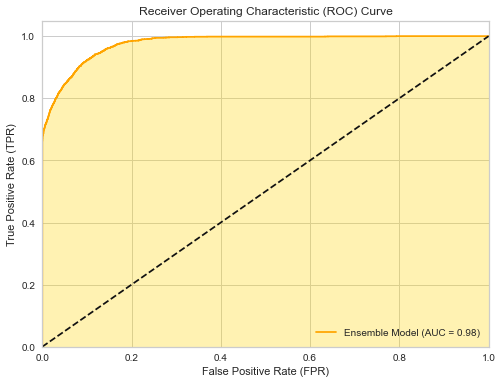

In [193]:
# Get the predicted probabilities for the positive class from the ensemble model
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = auc(fpr, tpr)

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label='Ensemble Model (AUC = {:.2f})'.format(auc_score))
plt.fill_between(fpr, tpr, color='gold', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Choosing 4 best models: XGBoost, ADABoost, LightGBM Model and Gradient Boosting, for Shap, Lime and CF

In [17]:
LGBoost = lgb.LGBMClassifier(subsample= 1.0, num_leaves= 80, min_child_samples= 20, max_depth= 5, learning_rate= 0.1, colsample_bytree= 1.0)
LGBoost.fit(X_train, y_train)

y_pred=LGBoost.predict(X_test)
print(f"Accuracy {accuracy_score(y_test,y_pred)}")

Accuracy 0.9710589036431733


In [40]:
XGBoost= xgb.XGBClassifier(n_estimators= 500, max_depth= 2, learning_rate= 0.1)
XGBoost.fit(X_train, y_train)

y_pred=XGBoost.predict(X_test)
print(f"Accuracy {accuracy_score(y_test,y_pred)}")

Accuracy 0.9712972420837589


In [19]:
ADABoost = AdaBoostClassifier(n_estimators=70, learning_rate=1.0, random_state=42)
ADABoost.fit(X_train, y_train)

y_pred=ADABoost.predict(X_test)
print(f"Accuracy {accuracy_score(y_test,y_pred)}")

Accuracy 0.9707184201566224


In [20]:
GradBoost = GradientBoostingClassifier(learning_rate= 0.2, max_depth= 2, max_features= 8, n_estimators= 212)
GradBoost.fit(X_train, y_train)

y_predg=GradBoost.predict(X_test)
print(f"Accuracy {accuracy_score(y_test,y_predg)}")

Accuracy 0.9711610486891386


## Creating a Pickle File for ADA Boost, Gradient Boosting and LightGBM Boosting Models

In [214]:
import pickle
pickle_out = open("ADABoost.pkl","wb")
pickle.dump(ADABoost,pickle_out)
pickle_out.close()

In [215]:
import pickle
pickle_out = open("GradBoost.pkl","wb")
pickle.dump(GradBoost,pickle_out)
pickle_out.close()

In [41]:
import pickle
pickle_out = open("XGBoost.pkl","wb")
pickle.dump(XGBoost,pickle_out)
pickle_out.close()

In [216]:
import pickle
pickle_out = open("LGBoost.pkl","wb")
pickle.dump(LGBoost,pickle_out)
pickle_out.close()

## Using Shap and Lime

In [29]:
import shap
import lime
import lime.lime_tabular

## Shap and Lime with ADA Boost Model

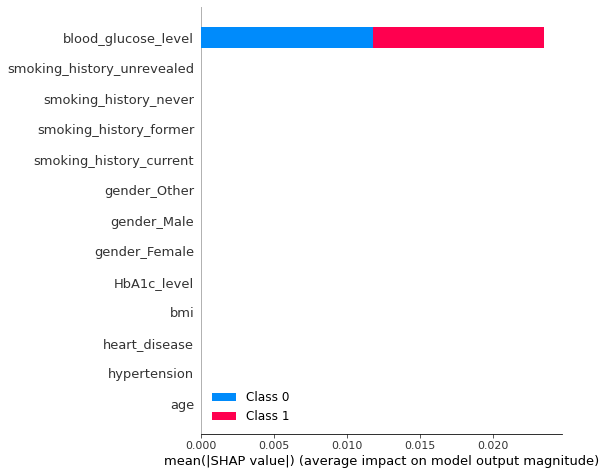

In [58]:
# Convert the AdaBoost model to a scikit-learn compatible decision tree-based model
ADABoost_as_tree = ADABoost.estimators_[65]

X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Calculate SHAP values for the test data
background_summary = shap.sample(X_test_df, 100)  # Adjust the sample size as needed
explainer = shap.TreeExplainer(ADABoost_as_tree)
shap_values = explainer.shap_values(X_test_df)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test_df)

In [219]:
# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'])

# Select an instance from the test data for explanation
instance = X_test.iloc[3]

# Explain the prediction for the selected instance
explanation = explainer.explain_instance(instance.values, GradBoost.predict_proba, num_features=len(X_train.columns))

# Print the explanation
explanation.show_in_notebook()

## Shap and Lime with Gradient Boost Model

 99%|===================| 29151/29370 [00:44<00:00]        

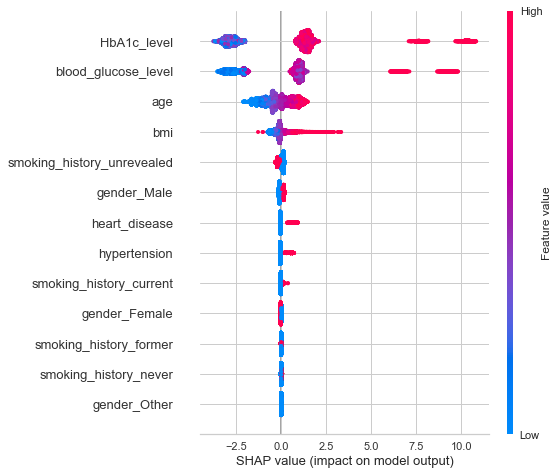

In [220]:
# Initialize the SHAP explainer
explainer = shap.Explainer(GradBoost, X_train)

# Calculate SHAP values for the test data
shap_values = explainer(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)

In [221]:
# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'])

# Select an instance from the test data for explanation
instance = X_test.iloc[3]

# Explain the prediction for the selected instance
explanation = explainer.explain_instance(instance.values, GradBoost.predict_proba, num_features=len(X_train.columns))

# Print the explanation
explanation.show_in_notebook()

## Shap and Lime with LightGBM Boosting Model

100%|===================| 29254/29370 [00:55<00:00]        

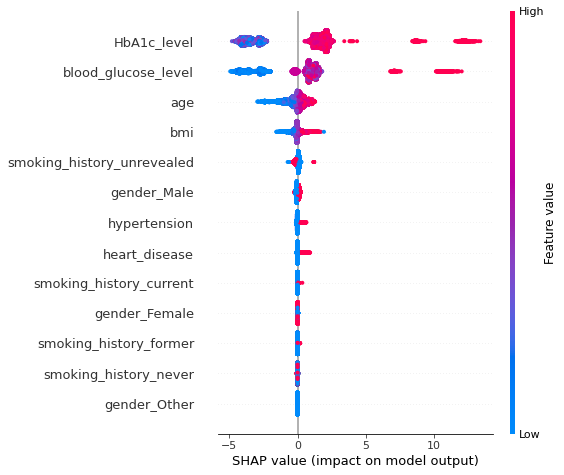

In [30]:
# Initialize the SHAP explainer
explainer = shap.Explainer(LGBoost, X_train)

# Calculate SHAP values for the test data
lg_shap_values = explainer(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(lg_shap_values, X_test)

In [223]:
# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'])

# Select an instance from the test data for explanation
instance = X_test.iloc[65]

# Explain the prediction for the selected instance
explanation = explainer.explain_instance(instance.values, LGBoost.predict_proba, num_features=len(X_train.columns))

# Print the explanation
explanation.show_in_notebook()

## Shap and Lime with XGBoosting Model

100%|===================| 29285/29370 [01:17<00:00]        

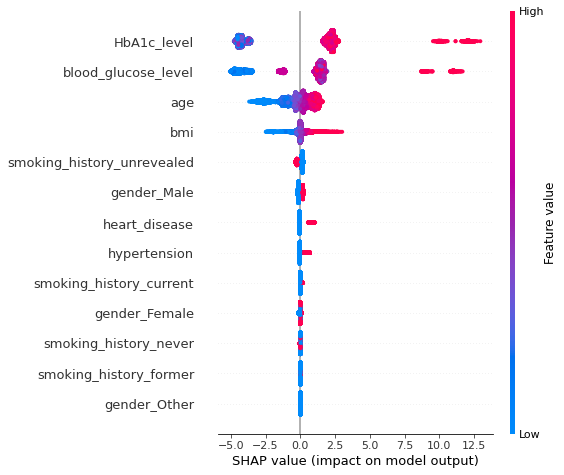

In [31]:
# Initialize the SHAP explainer
explainer = shap.Explainer(XGBoost, X_train)

# Calculate SHAP values for the test data
lg_shap_values = explainer(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(lg_shap_values, X_test)

In [32]:
# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'])

# Select an instance from the test data for explanation
instance = X_test.iloc[39]

# Explain the prediction for the selected instance
explanation = explainer.explain_instance(instance.values, XGBoost.predict_proba, num_features=len(X_train.columns))

# Print the explanation
explanation.show_in_notebook()

## CounterFactuals

In [34]:
import dice_ml
from dice_ml import Dice

## CounterFactuals using ADA Boosting Model

In [225]:
# Dataset for training an ML model

d=dice_ml.Data(dataframe= enc_data,
                 continuous_features=['bmi', 'blood_glucose_level', 'HbA1c_level'], 
                 discrete_features = ['gender', 'smoking_history', 'age'],
                 outcome_name='diabetes')

m=dice_ml.Model(model=ADABoost, backend='sklearn')

exp=dice_ml.Dice(d,m, method='random')

In [226]:
input_data = X_test[30:31]
input_data

age  hypertension  heart_disease   bmi  HbA1c_level  \
2127   52             0              0  25.9          4.8   

      blood_glucose_level  gender_Female  gender_Male  gender_Other  \
2127                  160              0            1             0   

      smoking_history_current  smoking_history_former  smoking_history_never  \
2127                        0                       1                      0   

      smoking_history_unrevealed  
2127                           0

In [227]:
features_to_vary=['bmi', 'blood_glucose_level','HbA1c_level']
permitted_range={'bmi':[15,45], 'blood_glucose_level':[80,250]}

CounterFactualEXP = exp.generate_counterfactuals(input_data, total_CFs=3, desired_class="opposite", permitted_range=permitted_range, features_to_vary=features_to_vary)
# Visualize counterfactual explanation
CounterFactualEXP.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

Query instance (original outcome : 0)


age hypertension heart_disease   bmi  HbA1c_level  blood_glucose_level  \
0  52            0             0  25.9          4.8                  160   

  gender_Female gender_Male gender_Other smoking_history_current  \
0             0           1            0                       0   

  smoking_history_former smoking_history_never smoking_history_unrevealed  \
0                      1                     0                          0   

   diabetes  
0         0


Diverse Counterfactual set (new outcome: 1.0)


age hypertension heart_disease                 bmi HbA1c_level  \
0  52.0          0.0           0.0  26.000000000000014         6.9   
1  52.0          0.0           0.0               18.01         8.1   
2  52.0          0.0           0.0  26.000000000000014         8.8   

  blood_glucose_level gender_Female gender_Male gender_Other  \
0               193.0           0.0         1.0          0.0   
1                   -           0.0         1.0          0.0   
2               150.0           0.0         1.0          0.0   

  smoking_history_current smoking_history_former smoking_history_never  \
0                     0.0                    1.0                   0.0   
1                     0.0                    1.0                   0.0   
2                     0.0                    1.0                   0.0   

  smoking_history_unrevealed diabetes  
0                        0.0      1.0  
1                        0.0      1.0  
2                        0.0      1.0

## CounterFactuals using Gradient Boosting Model

In [228]:
# Dataset for training an ML model

d=dice_ml.Data(dataframe= enc_data,
                 continuous_features=['bmi', 'blood_glucose_level', 'HbA1c_level'], 
                 discrete_features = ['gender', 'smoking_history', 'age'],
                 outcome_name='diabetes')

m=dice_ml.Model(model=GradBoost, backend='sklearn')

exp=dice_ml.Dice(d,m, method='random')

In [229]:
input_data = X_test[3:4]
input_data

age  hypertension  heart_disease    bmi  HbA1c_level  \
11432   51             0              0  27.32          6.0   

       blood_glucose_level  gender_Female  gender_Male  gender_Other  \
11432                  155              1            0             0   

       smoking_history_current  smoking_history_former  smoking_history_never  \
11432                        0                       0                      1   

       smoking_history_unrevealed  
11432                           0

In [230]:
features_to_vary=['bmi', 'blood_glucose_level','HbA1c_level']
permitted_range={'bmi':[15,45], 'blood_glucose_level':[80,250]}

CounterFactualEXP = exp.generate_counterfactuals(input_data, total_CFs=3, desired_class="opposite", permitted_range=permitted_range, features_to_vary=features_to_vary)
# Visualize counterfactual explanation
CounterFactualEXP.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

Query instance (original outcome : 0)


age hypertension heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  51            0             0  27.32          6.0                  155   

  gender_Female gender_Male gender_Other smoking_history_current  \
0             1           0            0                       0   

  smoking_history_former smoking_history_never smoking_history_unrevealed  \
0                      0                     1                          0   

   diabetes  
0         0


Diverse Counterfactual set (new outcome: 1.0)


age hypertension heart_disease                 bmi HbA1c_level  \
0  51.0          0.0           0.0   27.99999999999988           -   
1  51.0          0.0           0.0               37.79           -   
2  51.0          0.0           0.0  28.000000000000107         5.1   

  blood_glucose_level gender_Female gender_Male gender_Other  \
0               249.0           1.0         0.0          0.0   
1               244.0           1.0         0.0          0.0   
2               226.0           1.0         0.0          0.0   

  smoking_history_current smoking_history_former smoking_history_never  \
0                     0.0                    0.0                   1.0   
1                     0.0                    0.0                   1.0   
2                     0.0                    0.0                   1.0   

  smoking_history_unrevealed diabetes  
0                        0.0      1.0  
1                        0.0      1.0  
2                        0.0      1.0

## CounterFactuals using LightGBM Boosting Model

In [231]:
# Dataset for training an ML model

d=dice_ml.Data(dataframe= enc_data,
                 continuous_features=['bmi', 'blood_glucose_level', 'HbA1c_level'], 
                 discrete_features = ['gender', 'smoking_history', 'age'],
                 outcome_name='diabetes')

m=dice_ml.Model(model=LGBoost, backend='sklearn')

exp=dice_ml.Dice(d,m, method='random')

In [232]:
input_data = X_test[8:9]

features_to_vary=['bmi', 'blood_glucose_level','HbA1c_level']
permitted_range={'bmi':[15,45], 'blood_glucose_level':[80,250]}

CounterFactualEXP = exp.generate_counterfactuals(input_data, total_CFs=3, desired_class="opposite", permitted_range=permitted_range, features_to_vary=features_to_vary)
# Visualize counterfactual explanation
CounterFactualEXP.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

Query instance (original outcome : 0)


age hypertension heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  61            0             0  27.32          4.0                  145   

  gender_Female gender_Male gender_Other smoking_history_current  \
0             1           0            0                       1   

  smoking_history_former smoking_history_never smoking_history_unrevealed  \
0                      0                     0                          0   

   diabetes  
0         0


Diverse Counterfactual set (new outcome: 1.0)


age hypertension heart_disease                 bmi HbA1c_level  \
0  61.0          0.0           0.0  28.000000000000107         6.5   
1  61.0          0.0           0.0  28.000000000000107         7.8   
2  61.0          0.0           0.0                40.9           -   

  blood_glucose_level gender_Female gender_Male gender_Other  \
0               239.0           1.0         0.0          0.0   
1                84.0           1.0         0.0          0.0   
2               246.0           1.0         0.0          0.0   

  smoking_history_current smoking_history_former smoking_history_never  \
0                     1.0                    0.0                   0.0   
1                     1.0                    0.0                   0.0   
2                     1.0                    0.0                   0.0   

  smoking_history_unrevealed diabetes  
0                        0.0      1.0  
1                        0.0      1.0  
2                        0.0      1.0

## Shap and Lime with XGBoosting Model

In [35]:
# Dataset for training an ML model

d=dice_ml.Data(dataframe= enc_data,
                 continuous_features=['bmi', 'blood_glucose_level', 'HbA1c_level'], 
                 discrete_features = ['gender', 'smoking_history', 'age'],
                 outcome_name='diabetes')

m=dice_ml.Model(model=XGBoost, backend='sklearn')

exp=dice_ml.Dice(d,m, method='random')

In [36]:
input_data = X_test[27:28]

features_to_vary=['bmi', 'blood_glucose_level','HbA1c_level']
permitted_range={'bmi':[15,45], 'blood_glucose_level':[80,250]}

CounterFactualEXP = exp.generate_counterfactuals(input_data, total_CFs=3, desired_class="opposite", permitted_range=permitted_range, features_to_vary=features_to_vary)
# Visualize counterfactual explanation
CounterFactualEXP.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

Query instance (original outcome : 0)


age hypertension heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80            0             0  30.41          3.5                   85   

  gender_Female gender_Male gender_Other smoking_history_current  \
0             1           0            0                       0   

  smoking_history_former smoking_history_never smoking_history_unrevealed  \
0                      0                     1                          0   

   diabetes  
0         0


Diverse Counterfactual set (new outcome: 1.0)


age hypertension heart_disease                 bmi HbA1c_level  \
0  80.0          0.0           0.0  31.000000000000092           -   
1  80.0          0.0           0.0  31.000000000000092         8.2   
2  80.0          0.0           0.0               37.31         9.1   

  blood_glucose_level gender_Female gender_Male gender_Other  \
0               227.0           1.0         0.0          0.0   
1                   -           1.0         0.0          0.0   
2                   -           1.0         0.0          0.0   

  smoking_history_current smoking_history_former smoking_history_never  \
0                     0.0                    0.0                   1.0   
1                     0.0                    0.0                   1.0   
2                     0.0                    0.0                   1.0   

  smoking_history_unrevealed diabetes  
0                        0.0      1.0  
1                        0.0      1.0  
2                        0.0      1.0